In [14]:
import glob
from hera_cal import abscal
from hera_cal import io, utils
import copy
import numpy as np
from pathlib import Path
import os
import time

In [2]:
DATA_FILE = "/lustre/aoc/projects/hera/h6c-analysis/IDR2/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
ABSCAL_MIN_BL_LEN = 0
ABSCAL_MAX_BL_LEN =np.inf

In [4]:
Path(DATA_FILE).exists()

True

In [51]:
hd = io.HERAData(DATA_FILE)

In [8]:
abscal_model_files = sorted(glob.glob('/lustre/aoc/projects/hera/h6c-analysis/abscal_models/h6c_abscal_files_unique_baselines/zen.2458894.?????.uvh5'))
print(f'Found {len(abscal_model_files)} abscal model files{" in " + os.path.dirname(abscal_model_files[0]) if len(abscal_model_files) > 0 else ""}.')

Found 425 abscal model files in /lustre/aoc/projects/hera/h6c-analysis/abscal_models/h6c_abscal_files_unique_baselines.


In [11]:
abscal_start = time.time()
# figure out which model files match the LSTs of the data
matched_model_files = sorted(set(abscal.match_times(DATA_FILE, abscal_model_files, filetype='uvh5')))

# figure out appropriate model times to load
hdm = io.HERAData(matched_model_files)
all_model_times, all_model_lsts = abscal.get_all_times_and_lsts(hdm, unwrap=True)
d2m_time_map = abscal.get_d2m_time_map(hd.times, np.unwrap(hd.lsts), all_model_times, all_model_lsts, extrap_limit=.5)

In [15]:

# load matching times and baselines
#unflagged_data_bls = [bl for bl in vissol_flags if not np.all(vissol_flags[bl]) and bl[2] == pol]
unflagged_data_bls = hd.bls
data_bls = hd.bls

model_bls = copy.deepcopy(hdm.bls)
model_antpos = hdm.data_antpos

if len(matched_model_files) > 1:  # in this case, it's a dictionary
    model_bls = list(set([bl for bls in list(hdm.bls.values()) for bl in bls]))
    model_antpos = {ant: pos for antpos in hdm.data_antpos.values() for ant, pos in antpos.items()}

data_bls, model_bls, data_to_model_bl_map = abscal.match_baselines(
    unflagged_data_bls, model_bls, hd.antpos, model_antpos=model_antpos, 
    data_is_redsol=True, model_is_redundant=True, tol=1.0,
    min_bl_cut=ABSCAL_MIN_BL_LEN, max_bl_cut=ABSCAL_MAX_BL_LEN, verbose=True
)

model, model_flags, _ = io.partial_time_io(hdm, np.unique([d2m_time_map[time] for time in hd.times]), bls=model_bls)
model_bls = [data_to_model_bl_map[bl] for bl in data_bls]

# rephase model to match in lsts
model_blvecs = {bl: model.antpos[bl[0]] - model.antpos[bl[1]] for bl in model.keys()}
utils.lst_rephase(
    model, model_blvecs, model.freqs, hd.lsts - model.lsts,
    lat=hdm.telescope_location_lat_lon_alt_degrees[0], inplace=True
)

Selected 1672 data baselines and 1672 model baselines to load.


In [17]:
import matplotlib.pyplot as plt

In [19]:
model.freqs.size

1536

In [20]:
model.times

array([2458894.09853819, 2458894.09865004])

In [56]:
flags[(116, 10, 'ee')]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [57]:
data, flags, _ = hd.read()

In [30]:
len(model_bls)

1672

In [31]:
len(data_bls)

1672

(3, 10, 'nn') (np.int64(308), np.int64(315), 'nn') [-1.02254888e+02 -3.90517237e-01 -7.01682885e-02] [-1.02254856e+02 -3.90492844e-01  9.12992114e-03]
(51, 7, 'nn') (np.int64(308), np.int64(260), 'nn') [-117.05599547   50.16090897   -0.48045091] [-117.05595331   50.16090371   -0.42172863]
(166, 7, 'ee') (np.int64(314), np.int64(166), 'ee') [ -7.77096632 122.26784819  -1.00906129] [ -7.77091004 122.25780179  -1.20142362]
(162, 92, 'ne') (np.int64(311), np.int64(261), 'ne') [-87.87250967  58.7070119   -0.64026008] [-87.87245075  58.69699664  -0.55121775]
(8, 22, 'en') (np.int64(143), np.int64(166), 'en') [-43.79130818  -8.60190197   0.19008781] [-43.79130507  -8.60189297  -0.10021221]
(162, 50, 'ne') (np.int64(319), np.int64(206), 'ne') [65.42930597 80.37411323 -0.76870398] [65.42928288 80.37407409 -0.63131192]
(42, 3, 'ne') (np.int64(308), np.int64(266), 'ne') [21.76683048 38.03408958 -0.36928042] [21.76683438 38.03406667 -0.22028915]
(92, 4, 'ne') (np.int64(261), np.int64(144), 'ne') [

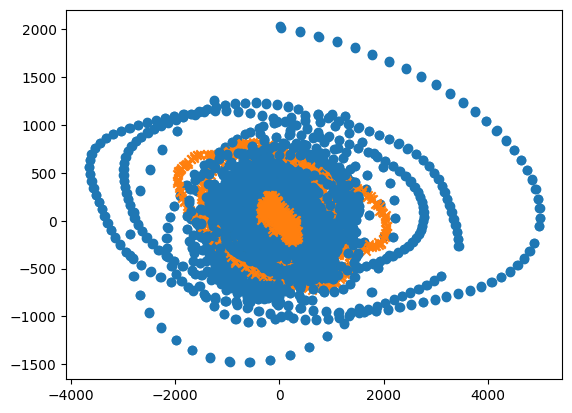

In [62]:
for dbl, mbl in zip(data_bls[::100], model_bls[::100]):
    print(dbl, mbl, hd.antpos[dbl[0]] - hd.antpos[dbl[1]], hd.antpos[mbl[0]] - hd.antpos[mbl[1]])
    mdl = np.where(flags[dbl], np.nan, model[mbl])
    d = np.where(flags[dbl], np.nan, data[dbl])
    plt.scatter(mdl.real.flatten(), mdl.imag.flatten(), color='C0')
    plt.scatter(d.real.flatten(), d.imag.flatten(), color='C1', marker='x')

(3, 10, 'nn')


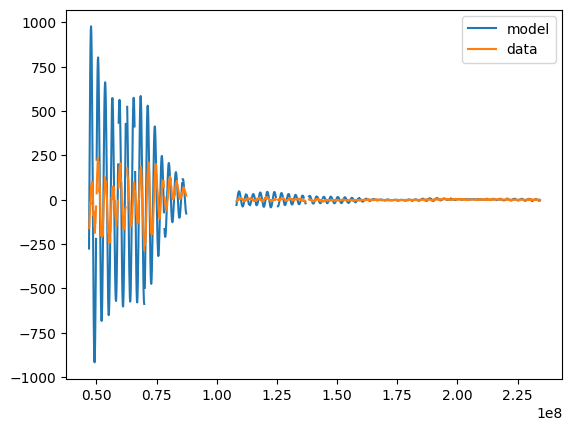

In [60]:
for dbl, mbl in zip(data_bls, model_bls):
    if np.all(flags[dbl][0]) or dbl[2][0] != dbl[2][1]:
        continue
        
    #print(dbl, mbl, hd.antpos[dbl[0]] - hd.antpos[dbl[1]], hd.antpos[mbl[0]] - hd.antpos[mbl[1]])
    plt.plot(hd.freqs, np.where(flags[dbl], np.nan, model[mbl])[0].real, color='C0', label='model')
    plt.plot(hd.freqs, np.where(flags[dbl], np.nan, data[dbl])[0].real, color='C1', label='data')
    plt.legend()
    # plt.scatter(data[dbl].real.flatten(), data[dbl].imag.flatten(), color='C1', marker='x')
    print(dbl)
    break

In [46]:
data[(143, 3, 'ee')]

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])